<a href="https://colab.research.google.com/github/doc-city/diveintocode-ml/blob/main/Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1 Execution of machine translation and code reading

In [4]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2021-09-20 22:14:10--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3033::ac43:ba36, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6451478 (6.2M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   6.15M  27.7MB/s    in 0.2s    

2021-09-20 22:14:10 (27.7 MB/s) - ‘fra-eng.zip’ saved [6451478/6451478]



In [5]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [6]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = './fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)


Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 13s 43ms/step - loss: 1.0969 - accuracy: 0.7385 - val_loss: 1.0362 - val_accuracy: 0.7123
Epoch 2/100
125/125 [==============================] - 4s 34ms/step - loss: 0.7935 - accuracy: 0.7836 - val_loss: 0.7986 - val_accuracy: 0.7757
Epoch 3/100
125/125 [==============================] - 4s 34ms/step - loss: 0.6452 - accuracy: 0.8174 - val_loss: 0.6935 - val_accuracy: 0.7965
Epoch 4/100
125/125 [==============================] - 4s 33ms/step - loss: 0.5652 - accuracy: 0.8352 - val_loss: 0.6342 - val_accuracy: 0.8154
Epoch 5/100
125/125 [==============================] - 4s 34ms/step - loss: 0.5203 - accuracy: 0.8476 - val_loss: 0.5832 - val_accuracy: 0.8331
Epoch 6/100
125/125 [==============================] - 4s 33ms/step - loss: 0.4869 - accuracy: 0.8562 - val_loss: 

# Problem 2 Execution of a trained model of image captioning

In [7]:
from IPython.display import Image, display_png

In [8]:
#!git clone https://github.com/pdollar/coco.git

In [9]:
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0

--2021-09-20 22:23:19--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2021-09-20 22:23:19--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb9cc36aff7e5493b2d3e281760.dl.dropboxusercontent.com/cd/0/inline/BWiUGc0tBxBtj4QpyqRr9NfXwMEbYR6_QqiEL1VeNUOb3NCueT-UqytHw4ETLRGEt_kwJ-jkPqL5l-OXD3SlnLSIoPz9yUBWIKjD-dwKz7JUT34wweJdvxjQs0UHoic2ajyHZbzN_01r-GLjA-1AEnr3/file# [following]
--2021-09-20 22:23:19--  https://ucb9cc36aff7e5493b2d3e281760.dl.dropboxusercontent.com/cd/0/inline/BWiUGc0tBxBtj4QpyqRr9NfXwMEbYR6_QqiEL1VeNUOb3NCueT-UqytHw4ETL

In [10]:
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0

--2021-09-20 22:23:26--  https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/26adb7y9m98uisa/vocap.zip [following]
--2021-09-20 22:23:26--  https://www.dropbox.com/s/raw/26adb7y9m98uisa/vocap.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4edb1267b6f51fff19a972f209.dl.dropboxusercontent.com/cd/0/inline/BWh_UL9VwuQlBXJze_UZjsjKj-xI_Ljmn1CLIly2w4Ub4H1_CHq-xX8txUiOWx3TwGBu2Wi68Rkc6jtNpEpYRYFQGbT5CBCgqUlJ1qsUusrBSpFLm_85ltK132Hdq4k5MVxjyCteDNOaQyaEO9iBosk0/file# [following]
--2021-09-20 22:23:27--  https://uc4edb1267b6f51fff19a972f209.dl.dropboxusercontent.com/cd/0/inline/BWh_UL9VwuQlBXJze_UZjsjKj-xI_Ljmn1CLIly2w4Ub4H1_CHq-xX8txUiOWx3TwGBu2Wi68Rkc6jtNpEpYRYFQGbT5C

In [12]:
!unzip pretrained_model.zip?dl=0

Archive:  pretrained_model.zip?dl=0
  inflating: encoder-5-3000.pkl      
  inflating: decoder-5-3000.pkl      


In [14]:
!unzip vocap.zip?dl=0

Archive:  vocap.zip?dl=0
  inflating: vocab.pkl               


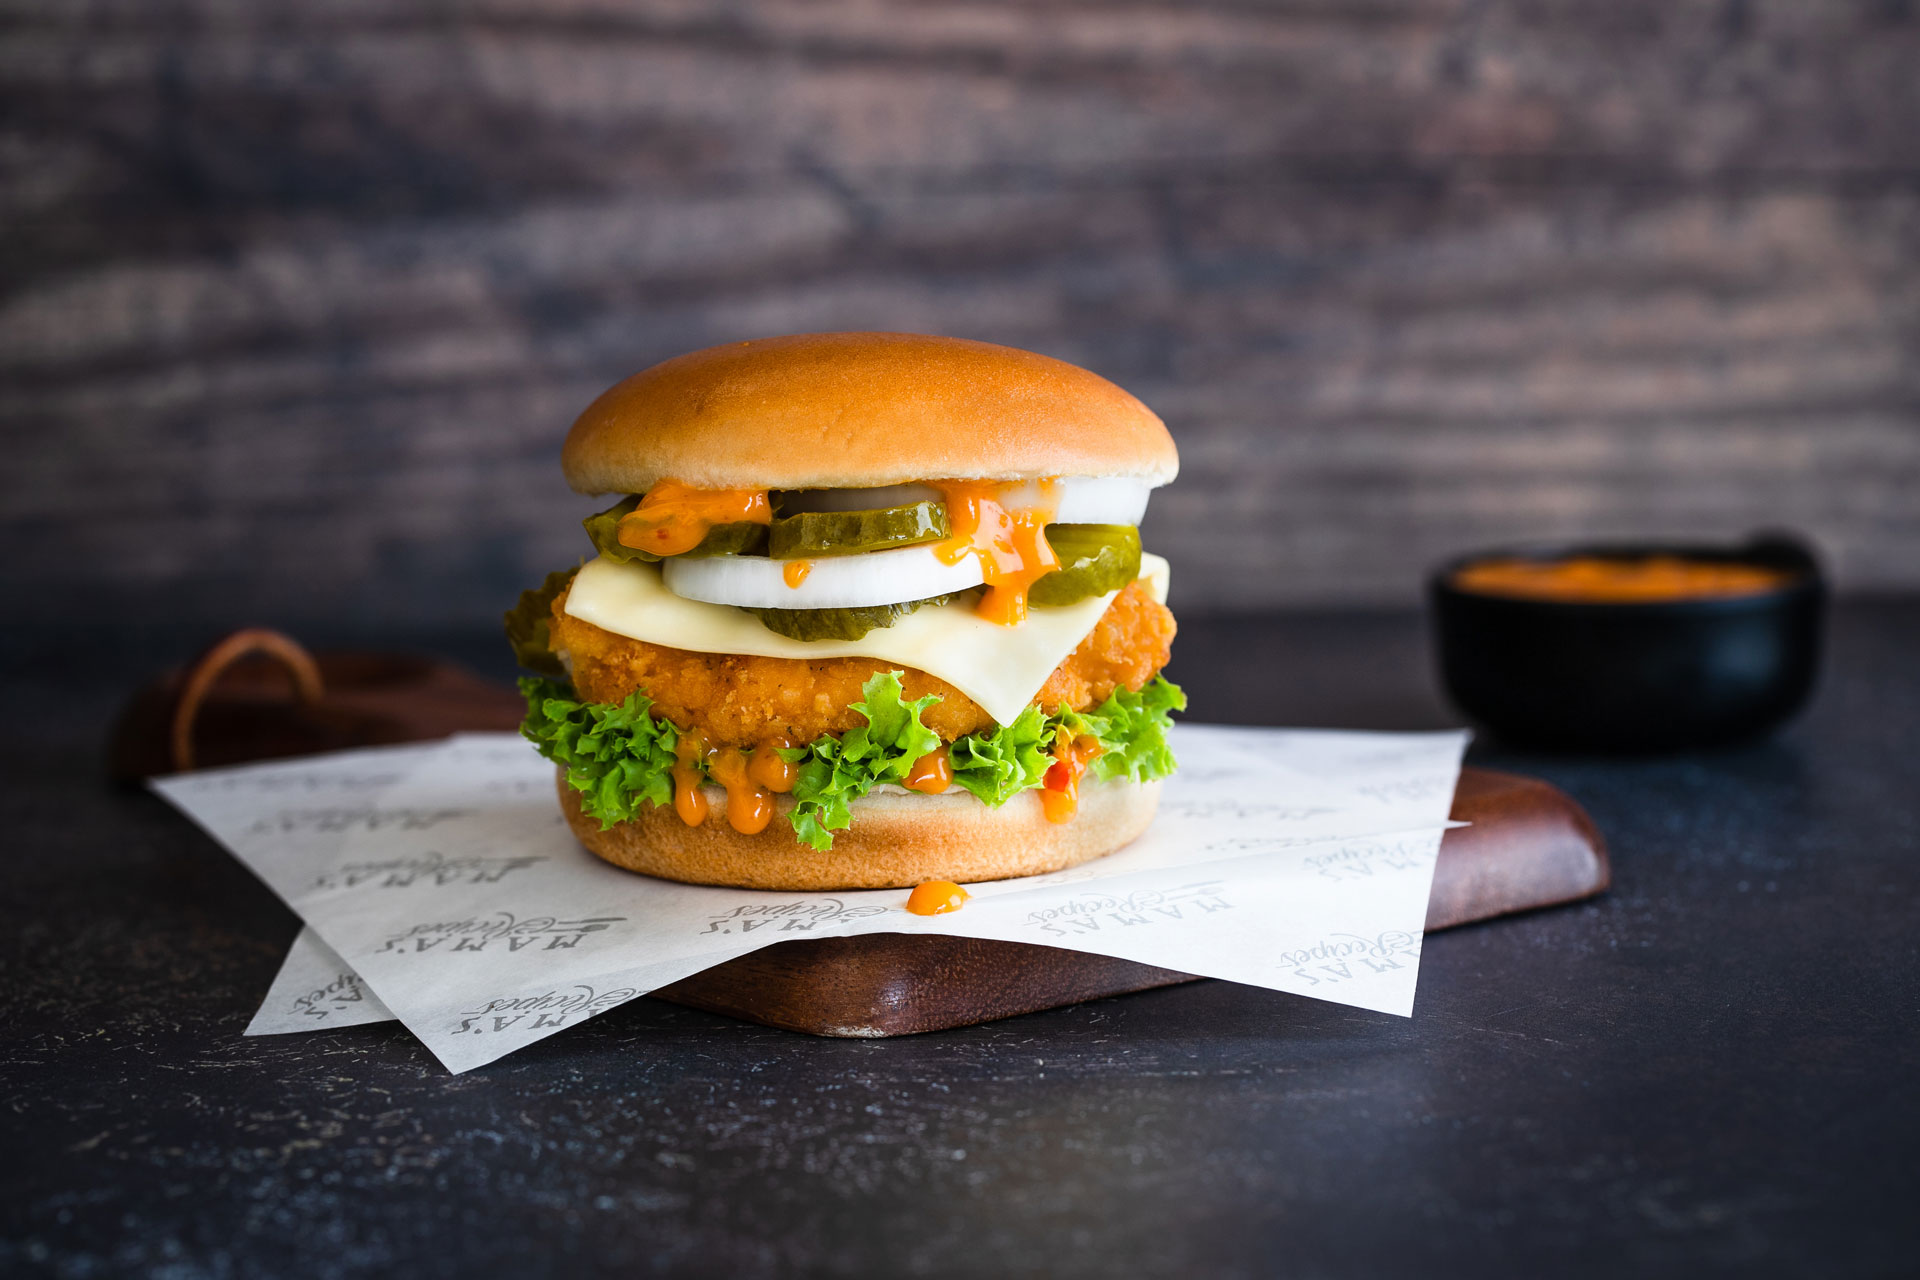

In [18]:
Image(data="/content/foofd.jpg", width=300, height=300)


 # Problem 3 Investigate what to do if you want to move with Keras

Make it available to Keras via the ONNX format ONN stands for Open Neural Network eXchange.

Format for exchanging deep learning models between various frameworks
By the way, ONNX is pronounced "Onyx"

procedure

Convert the model learned by Pytorch to ONNX format and save it


Convert ONNX format model to Keras model


Convert Keras model from channel_first format to channel_last format


Save Keras model as saved_model.pb


Commentary

Not all frameworks can convert to each other
reference

Official Github
https://github.com/onnx/tutorials

# Problem 4 (Advance task) Code reading and rewriting

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Dropout, Conv2D
from keras.callbacks import EarlyStopping

In [20]:
encorder_inputs = Input(shape=(None, ))

# Problem 5 (Advance issue) Developmental survey

In [21]:
with open("fra.txt", "r") as f:
  i = 0
  for r in f:
    print(r)
    i += 1
    if i==30:
      break

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)

Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)

Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)

Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)

Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)

Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)

Run!	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)

Run!	Prenez vos jambes à vos cous !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077449 (sacredceltic)

Run!	File !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077454 (sacredceltic)

Run!	Filez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077455 (sacredceltic)

Run!	Cou

In [22]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = './fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [23]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

print(input_token_index)
print(target_token_index)

{' ': 0, '!': 1, '"': 2, '$': 3, '%': 4, '&': 5, "'": 6, ',': 7, '-': 8, '.': 9, '0': 10, '1': 11, '2': 12, '3': 13, '5': 14, '7': 15, '8': 16, '9': 17, ':': 18, '?': 19, 'A': 20, 'B': 21, 'C': 22, 'D': 23, 'E': 24, 'F': 25, 'G': 26, 'H': 27, 'I': 28, 'J': 29, 'K': 30, 'L': 31, 'M': 32, 'N': 33, 'O': 34, 'P': 35, 'Q': 36, 'R': 37, 'S': 38, 'T': 39, 'U': 40, 'V': 41, 'W': 42, 'Y': 43, 'a': 44, 'b': 45, 'c': 46, 'd': 47, 'e': 48, 'f': 49, 'g': 50, 'h': 51, 'i': 52, 'j': 53, 'k': 54, 'l': 55, 'm': 56, 'n': 57, 'o': 58, 'p': 59, 'q': 60, 'r': 61, 's': 62, 't': 63, 'u': 64, 'v': 65, 'w': 66, 'x': 67, 'y': 68, 'z': 69, 'é': 70}
{'\t': 0, '\n': 1, ' ': 2, '!': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, ',': 9, '-': 10, '.': 11, '0': 12, '1': 13, '2': 14, '3': 15, '5': 16, '8': 17, '9': 18, ':': 19, '?': 20, 'A': 21, 'B': 22, 'C': 23, 'D': 24, 'E': 25, 'F': 26, 'G': 27, 'H': 28, 'I': 29, 'J': 30, 'K': 31, 'L': 32, 'M': 33, 'N': 34, 'O': 35, 'P': 36, 'Q': 37, 'R': 38, 'S': 39, 'T': 40, 'U': 41,

In [24]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

np.set_printoptions(edgeitems=50)
print(input_texts[3])
print(encoder_input_data[2,:,:])


Hi.
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [25]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

#Test
tmp = Model(encoder_inputs, encoder_outputs)
tmp.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, 71)]        0         
_________________________________________________________________
lstm_2 (LSTM)                [(None, 256), (None, 256) 335872    
Total params: 335,872
Trainable params: 335,872
Non-trainable params: 0
_________________________________________________________________


In [26]:
encoder_states[0]

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm_2')>

In [27]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Epoch 1/100
125/125 [==============================] - 8s 42ms/step - loss: 1.1420 - accuracy: 0.7354 - val_loss: 1.0118 - val_accuracy: 0.7237
Epoch 2/100
125/125 [==============================] - 4s 33ms/step - loss: 0.8174 - accuracy: 0.7791 - val_loss: 0.8196 - val_accuracy: 0.7716
Epoch 3/100
125/125 [==============================] - 4s 33ms/step - loss: 0.6585 - accuracy: 0.8156 - val_loss: 0.6944 - val_accuracy: 0.8009
Epoch 4/100
125/125 [==============================] - 4s 33ms/step - loss: 0.5730 - accuracy: 0.8333 - val_loss: 0.6435 - val_accuracy: 0.8143
Epoch 5/100
125/125 [==============================] - 4s 34ms/step - loss: 0.5273 - accuracy: 0.8455 - val_loss: 0.6053 - val_accuracy: 0.8247
Epoch 6/100
125/125 [==============================] - 4s 33ms/step - loss: 0.4930 - accuracy: 0.8546 - val_loss: 0.5674 - val_accuracy: 0.8335
Epoch 7/100
125/125 [==============================] - 4s 33ms/step - loss: 0.4648 - accuracy: 0.8622 - val_loss: 0.5472 - val_accuracy: